In [1]:
import functions as f
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


url_1 = '../data/raw/SYB67_176_202411_Tourist-Visitors Arrival and Expenditure.csv'
df_1 = pd.read_csv(url_1)

url_2 = '../data/raw/SYB67_285_202411_Research and Development Expenditure and Staff.csv'
df_2 = pd.read_csv(url_2)

url_3 = '../data/raw/SYB67_328_202411_Intentional homicides and other crimes.csv'
df_3 = pd.read_csv(url_3)

url_4 = '../data/raw/SYB67_329_202411_Labour Force and Unemployment.csv'
df_4 = pd.read_csv(url_4)

#Function to clean rows and columns
df_1 = f.clean_row_column(df_1,url_1)
df_2 = f.clean_row_column(df_2,url_2)
df_3 = f.clean_row_column(df_3,url_3)
df_4 = f.clean_row_column(df_4,url_4)

#Function to insert column type
df_1 = f.insert_column(df_1,"Type","Tourism")
df_2 = f.insert_column(df_2,"Type","R&D")
df_3 = f.insert_column(df_3,"Type","Crime")
df_4 = f.insert_column(df_4,"Type","Labour & Unemployment")

#Concat all the dataframes.
df = pd.concat([df_1,df_2,df_3,df_4], axis=0)

#Format column names
df = df.rename(columns={col: col.rstrip().replace(" ", "_").lower() for col in df.columns})

#Drop irrelevant columns
df = df.drop(columns=['source','tourism_arrivals_series_type_footnote'])

#Replace N/A values for tourism_arrivals_series_type column
df.loc[df['type'] == 'Tourism', 'tourism_arrivals_series_type'] = df.loc[df['type'] == 'Tourism', 'tourism_arrivals_series_type'].fillna("TE")

#Convert the data type of value column to float as well check if value is string and then remove the commas also
df['value'] = df['value'].astype(str).str.replace(',', '').astype(float)


#Apply the function to create a new column 'Continent'
df['continent'] = df['region/country/area'].apply(f.get_continent)



### crime section

#### type of crime per 100,000 inhabitants by country

type of crime per 100,000 inhabitants by country:


<Figure size 1500x800 with 0 Axes>

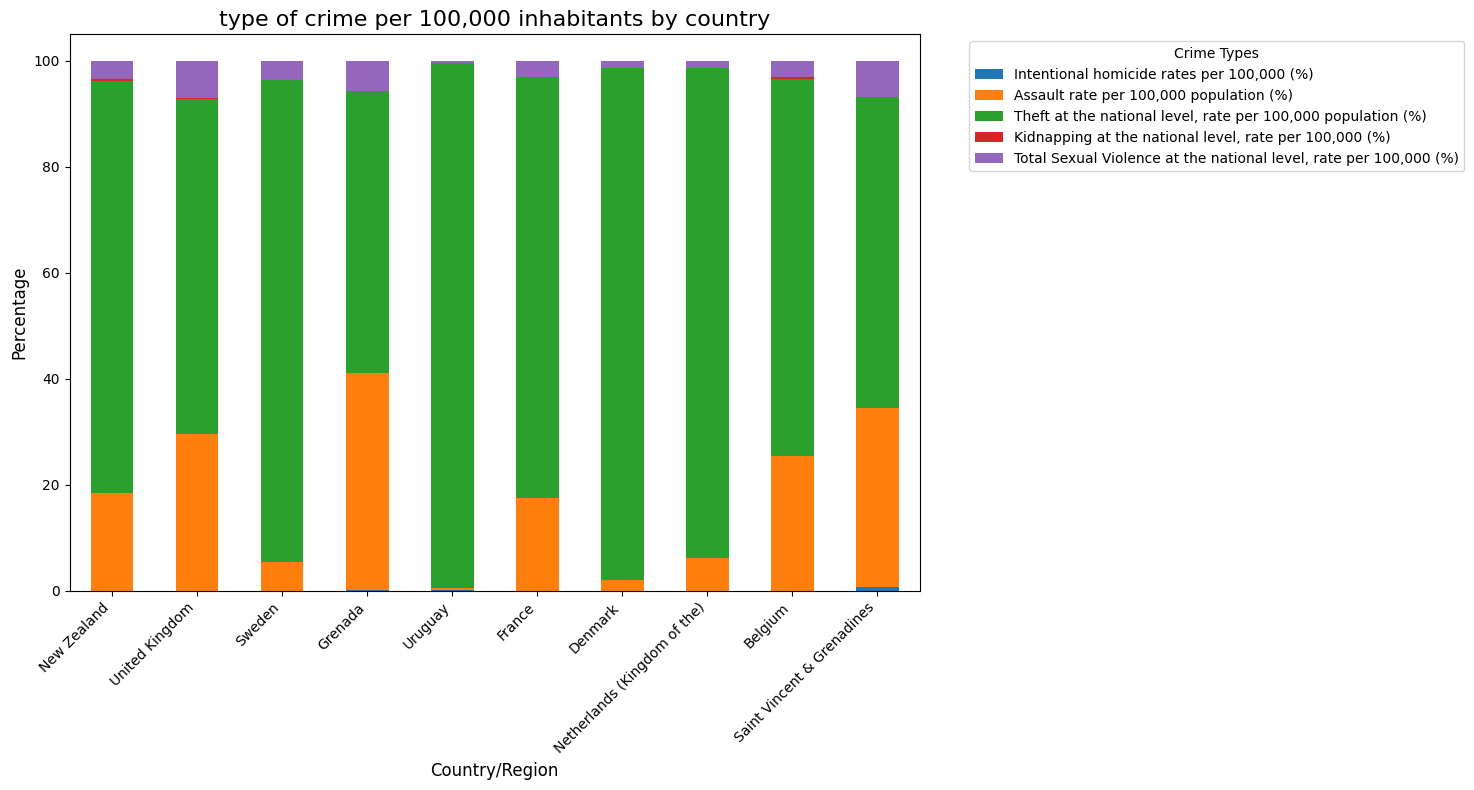

In [2]:

# Assuming 'df' is your original DataFrame
crime_types = ['Intentional homicide rates per 100,000',
               'Assault rate per 100,000 population', 
               'Theft at the national level, rate per 100,000 population',
               'Kidnapping at the national level, rate per 100,000',
               'Total Sexual Violence at the national level, rate per 100,000']

crime_type = df[df["series"].isin(crime_types)]


# Pivot the data
pivot_df = crime_type.pivot_table(
    index='region/country/area', 
    columns='series', 
    values='value', 
    aggfunc='sum'
)

# Rename columns
pivot_df.columns = [col.split(':')[0].strip() for col in pivot_df.columns]

# Fill missing values with 0
pivot_df = pivot_df.fillna(0)

# Calculate total victims
pivot_df['Total Victims'] = pivot_df.sum(axis=1)

# Calculate percentages
for col in crime_types:
    col_name = col.split(':')[0].strip()
    pivot_df[f'{col_name} (%)'] = (pivot_df[col_name] / pivot_df['Total Victims']) * 100

# Sort by total number of victims and select the top 10 regions
top_10_regions = pivot_df.sort_values('Total Victims', ascending=False).head(10)

print("type of crime per 100,000 inhabitants by country:")


# Plotting
plt.figure(figsize=(15, 8))
top_10_regions[[col for col in pivot_df.columns if '(%)' in col]].plot(
    kind='bar', stacked=True, figsize=(15, 8)
)
plt.title("type of crime per 100,000 inhabitants by country", fontsize=16)
plt.xlabel("Country/Region", fontsize=12)
plt.ylabel("Percentage", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title="Crime Types", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


#### display crime separatly

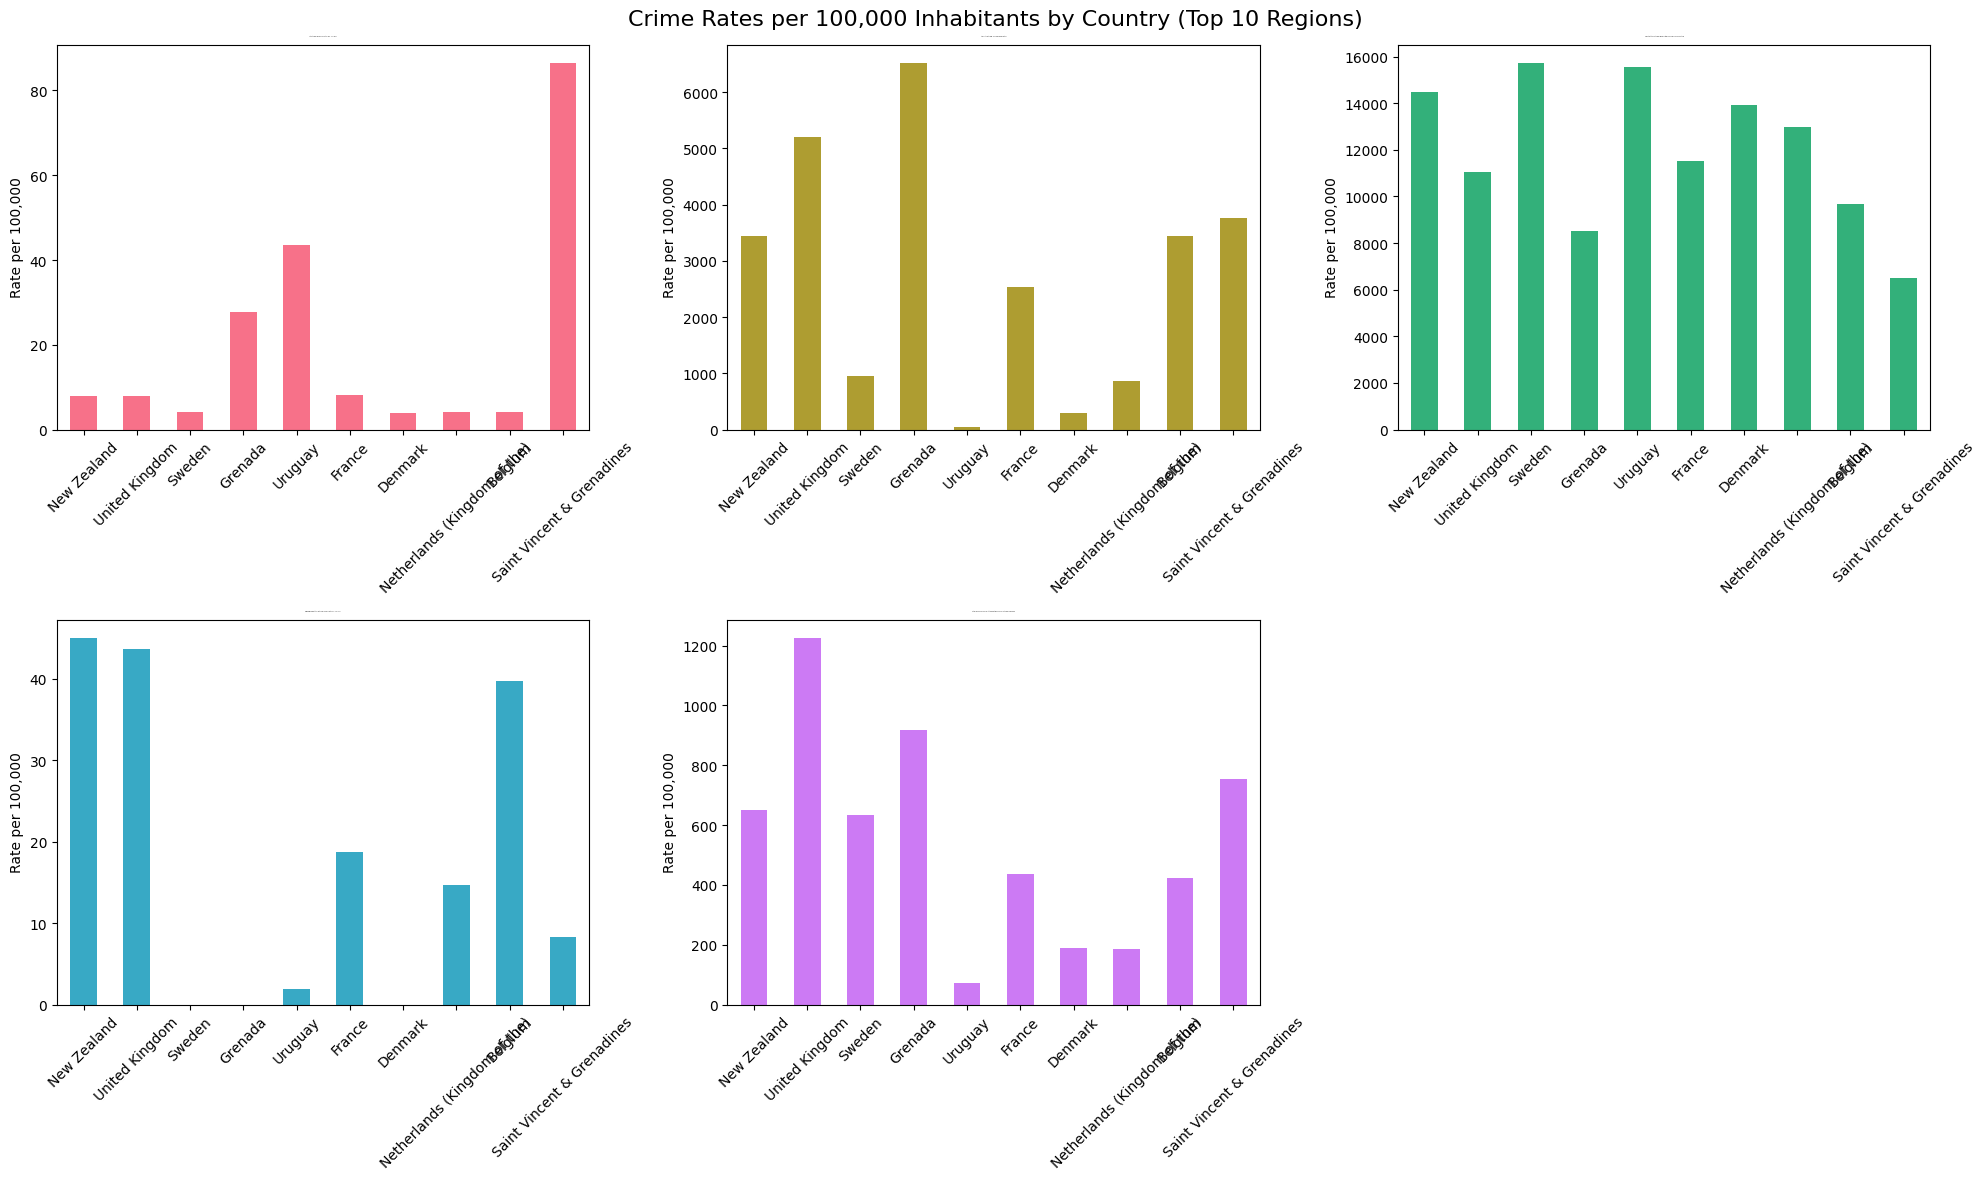

In [3]:

# Assuming 'df' is your original DataFrame
crime_types = ['Intentional homicide rates per 100,000',
               'Assault rate per 100,000 population', 
               'Theft at the national level, rate per 100,000 population',
               'Kidnapping at the national level, rate per 100,000',
               'Total Sexual Violence at the national level, rate per 100,000']

# Pivot the data
pivot_df = df.pivot_table(
    index='region/country/area', 
    columns='series', 
    values='value', 
    aggfunc='sum'
)

# Rename columns
pivot_df.columns = [col.split(':')[0].strip() for col in pivot_df.columns]

# Fill missing values with 0
pivot_df = pivot_df.fillna(0)

# Calculate total victims
pivot_df['Total Victims'] = pivot_df[crime_types].sum(axis=1)

# Sort by total number of victims and select the top 10 regions
top_10_regions = pivot_df.sort_values('Total Victims', ascending=False).head(10)

# Create a color palette
colors = sns.color_palette("husl", len(crime_types))

# Create subplots for each crime type
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))
fig.suptitle("Crime Rates per 100,000 Inhabitants by Country (Top 10 Regions)", fontsize=16)

for i, crime in enumerate(crime_types):
    row = i // 3
    col = i % 3
    top_10_regions[crime].plot(kind='bar', ax=axes[row, col], color=colors[i])
    axes[row, col].set_title(crime, fontsize=1)
    axes[row, col].set_xlabel("")
    axes[row, col].set_ylabel("Rate per 100,000")
    axes[row, col].tick_params(axis='x', rotation=45)

# Remove the empty subplot
if len(crime_types) < 6:
    fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.show()


####  Percentage of homicides by sex (male/female) / display by country

Top 10 regions with the highest number of homicide victims:
                            Total Victims  Female Percentage  Male Percentage
region/country/area                                                          
Jamaica                             547.3           9.738717        90.261283
El Salvador                         506.1           9.899229        90.100771
Belize                              390.4          10.860656        89.139344
Venezuela (Boliv. Rep. of)          362.1           5.412869        94.587131
Saint Kitts and Nevis               343.2           4.807692        95.192308
Honduras                            331.7           7.868556        92.131444
Colombia                            313.5           8.006380        91.993620
Brazil                              308.0           8.019481        91.980519
Trinidad and Tobago                 305.4           9.855927        90.144073
Guatemala                           304.6          11.950098        88.049902


<Figure size 1200x600 with 0 Axes>

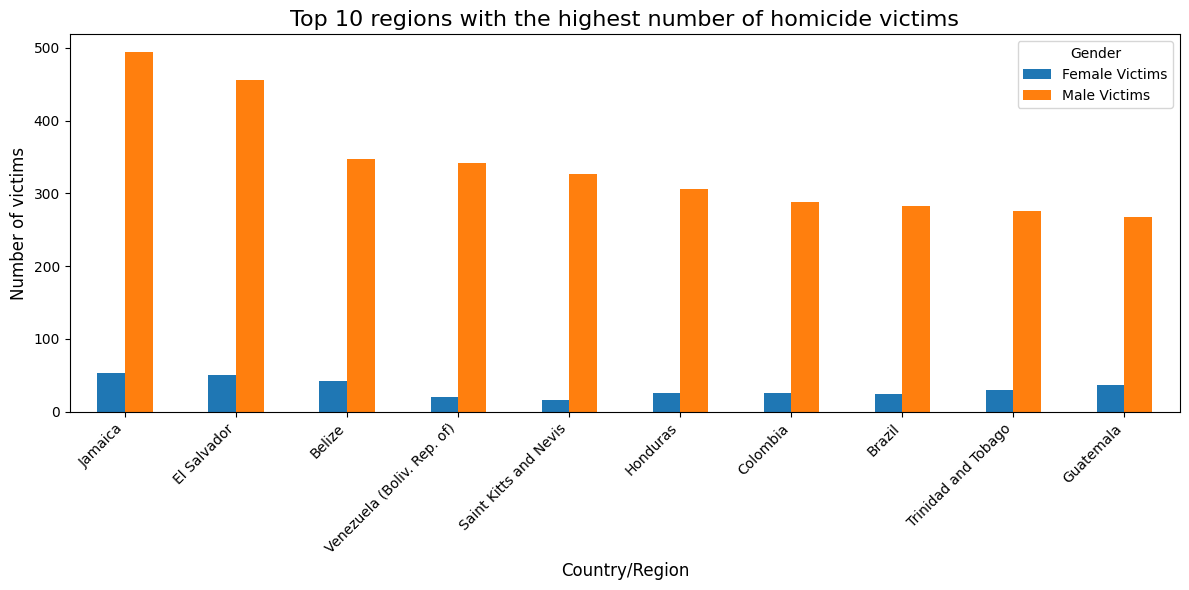

In [4]:
# Filter data 
filtered_df = df[df['series'].isin([
    'Percentage of male and female intentional homicide victims, Male',
    'Percentage of male and female intentional homicide victims, Female'
])]

#  Reorganize data to have separate columns for men and women
pivot_df = filtered_df.pivot_table(
    index='region/country/area', 
    columns='series', 
    values='value', 
    aggfunc='sum'
)

# Rename columns
pivot_df.columns = ['Female Victims', 'Male Victims']

# Fill in missing values with 0
pivot_df = pivot_df.fillna(0)

# Calculate total victims and percentages
pivot_df['Total Victims'] = pivot_df['Female Victims'] + pivot_df['Male Victims']
pivot_df['Female Percentage'] = (pivot_df['Female Victims'] / pivot_df['Total Victims']) * 100
pivot_df['Male Percentage'] = (pivot_df['Male Victims'] / pivot_df['Total Victims']) * 100


# Sort by total number of victims and select the top 10 regions
top_10_regions = pivot_df.sort_values('Total Victims', ascending=False).head(10)
print("Top 10 regions with the highest number of homicide victims:")
print(top_10_regions[['Total Victims', 'Female Percentage', 'Male Percentage']])

# Create a multiple bar plot using plot.bar()
plt.figure(figsize=(12, 6))
top_10_regions[['Female Victims', 'Male Victims']].plot.bar(figsize=(12, 6))

plt.title("Top 10 regions with the highest number of homicide victims", fontsize=16)
plt.xlabel("Country/Region", fontsize=12)
plt.ylabel("Number of victims", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title="Gender", loc="upper right")
plt.tight_layout()
plt.show()


### Evolution of crime over years

NameError: name 'mdates' is not defined

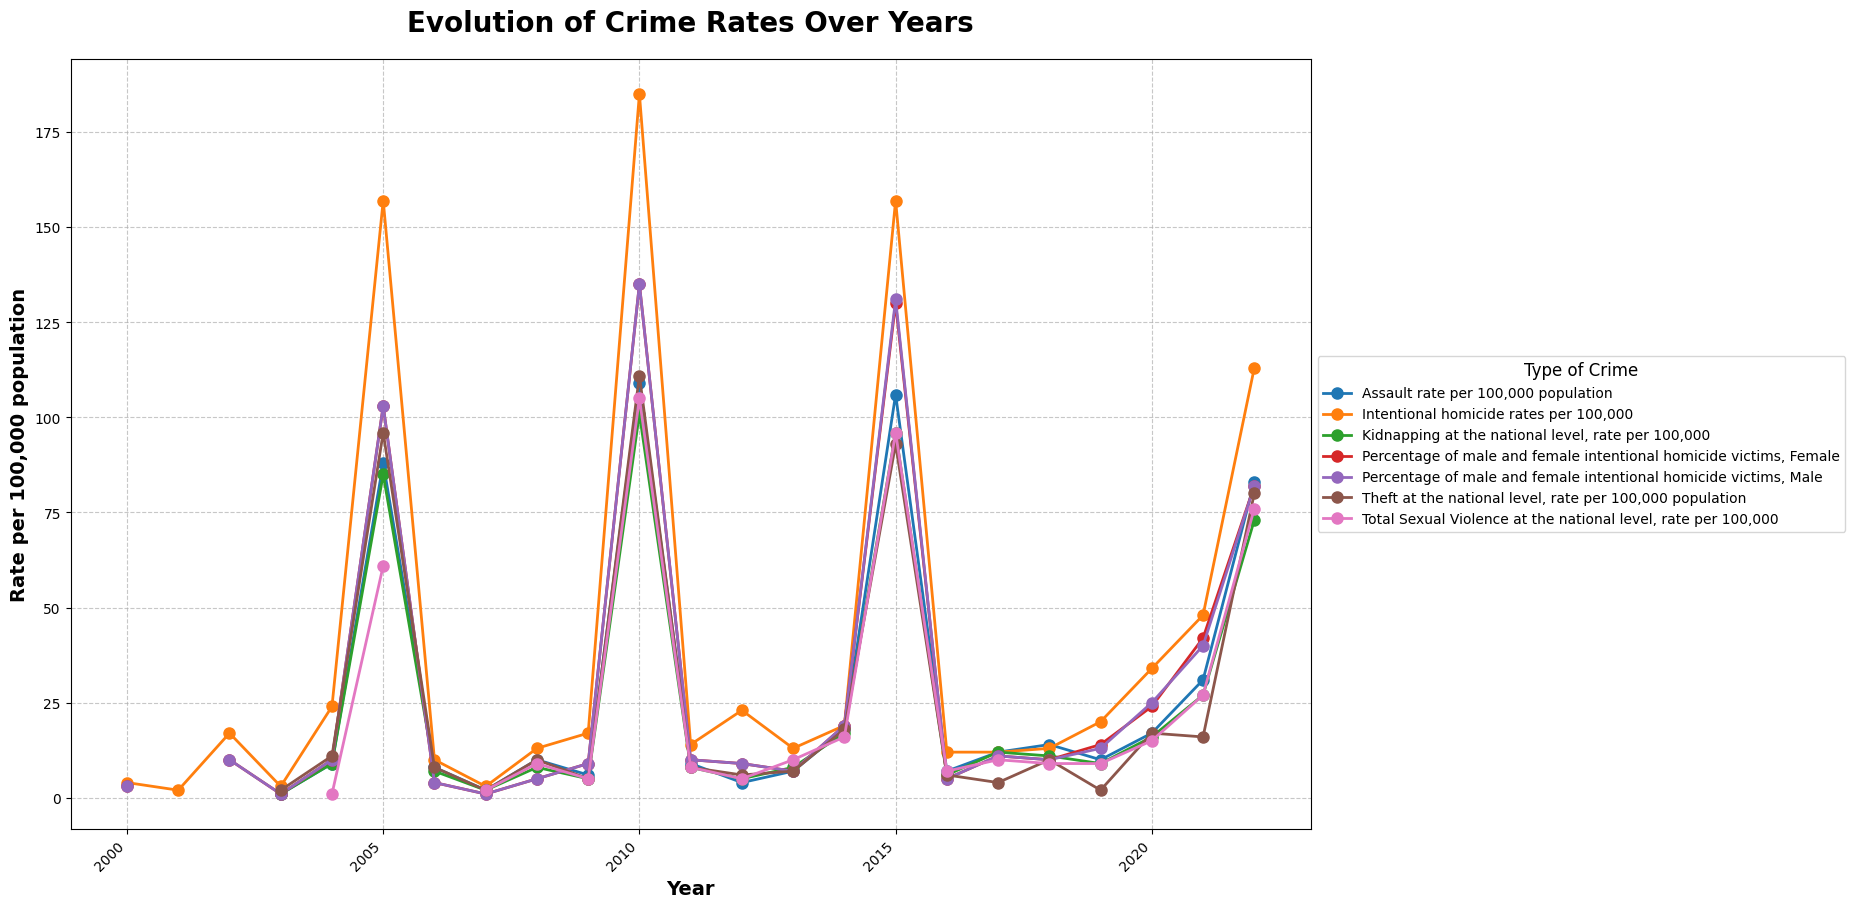

In [5]:
crime_types = ['Intentional homicide rates per 100,000',
               'Assault rate per 100,000 population', 
               'Theft at the national level, rate per 100,000 population',
               'Kidnapping at the national level, rate per 100,000',
               'Total Sexual Violence at the national level, rate per 100,000']

crime_df =df[df['type']=='Crime']


#regrouper les donnees par annee et serie
evolution=crime_df.groupby(['year','series']).size().unstack()



# Create a larger figure
plt.figure(figsize=(16, 10), dpi=100)

# Plot the data with enhanced styling
for column in evolution.columns:
    plt.plot(evolution.index, evolution[column], marker='o', linewidth=2, markersize=8, label=column)

# Set title and labels with improved typography
plt.title("Evolution of Crime Rates Over Years", fontsize=20, fontweight='bold', pad=20)
plt.xlabel("Year", fontsize=14, fontweight='bold')
plt.ylabel("Rate per 100,000 population", fontsize=14, fontweight='bold')

# Enhance the legend
plt.legend(title='Type of Crime', title_fontsize=12, fontsize=10, loc='center left', bbox_to_anchor=(1, 0.5))

# Improve grid appearance
plt.grid(True, linestyle='--', alpha=0.7)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Format x-axis to show all years
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Add minor ticks for better readability
plt.gca().yaxis.set_minor_locator(plt.AutoMinorLocator())

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()